<a href="https://colab.research.google.com/github/crisfabaper1/repositorio/blob/main/Proyecto_Datos_Financieros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

# 📌 1. Recolección de Datos

In [2]:
import yfinance as yf
import pandas as pd
df=yf.download("USDCOP=X",start="2022-01-01",end="2025-04-01")
df.to_csv("USD_COP.csv")
df.tail(5)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,USDCOP=X,USDCOP=X,USDCOP=X,USDCOP=X,USDCOP=X
Date,,,,,
2025-03-25,4143.910156,4146.069824,4105.310059,4143.910156,0
2025-03-26,4102.000000,4139.729980,4102.000000,4102.000000,0
2025-03-27,4130.180176,4154.540039,4129.529785,4130.180176,0
2025-03-28,4166.500000,4180.209961,4165.600098,4166.500000,0
2025-03-31,4125.830078,4200.379883,4096.534180,4125.830078,0


# Análisis Exploratorio de Datos

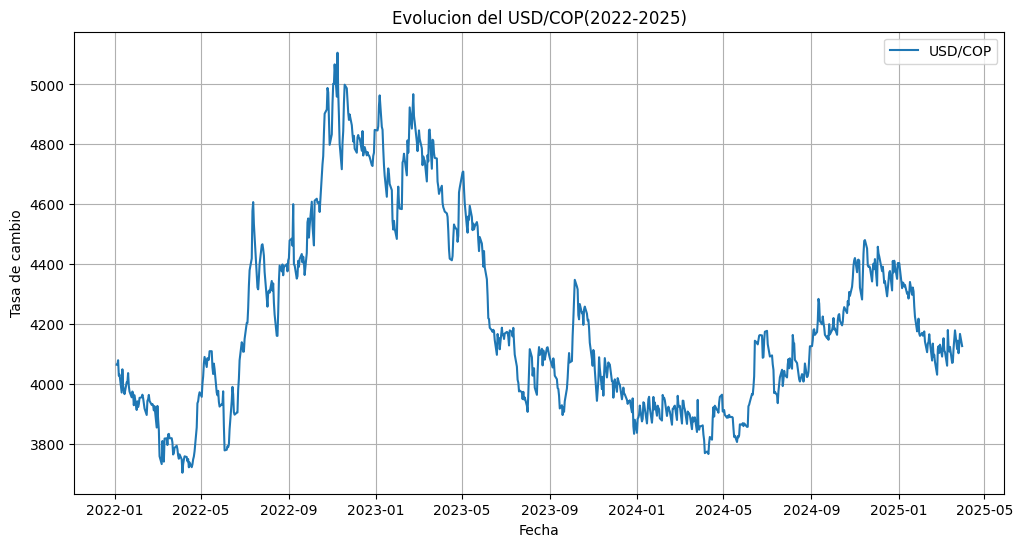

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df['Close'],label='USD/COP')
plt.title('Evolucion del USD/COP(2022-2025)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de cambio')
plt.legend()
plt.grid(True)
plt.show()


# Calculo de indicadores tecnicos

# Vamos a calcular y graficar algunos indicadores técnicos para entender mejor el comportamiento del USD/COP:

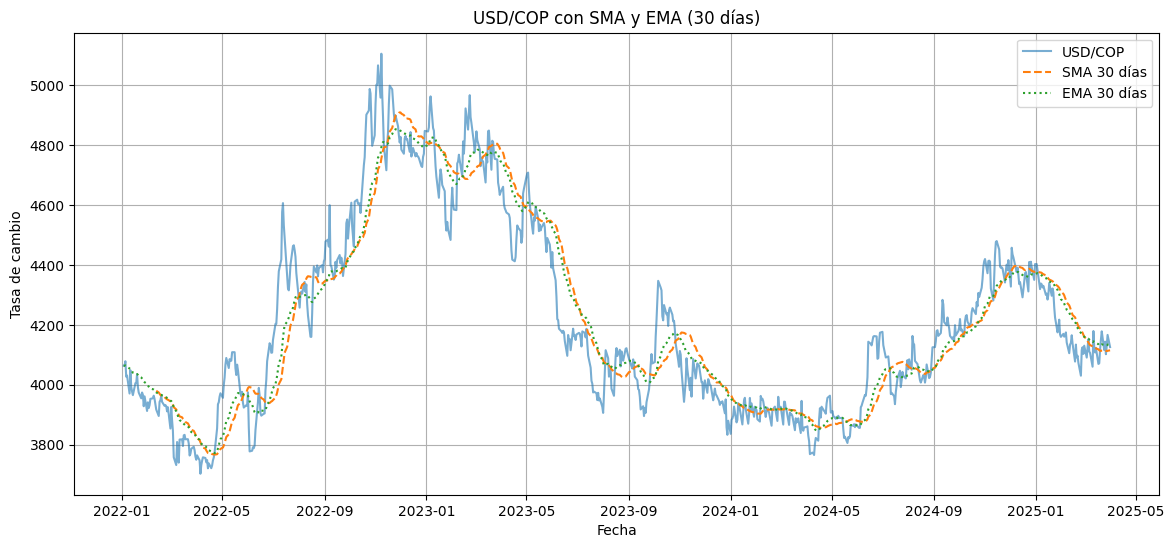

In [6]:
# Media Móvil Simple y Exponencial
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

# Gráfica de las medias móviles
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='USD/COP', alpha=0.6)
plt.plot(df['SMA_30'], label='SMA 30 días', linestyle='--')
plt.plot(df['EMA_30'], label='EMA 30 días', linestyle=':')
plt.title('USD/COP con SMA y EMA (30 días)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de cambio')
plt.legend()
plt.grid(True)
plt.show()

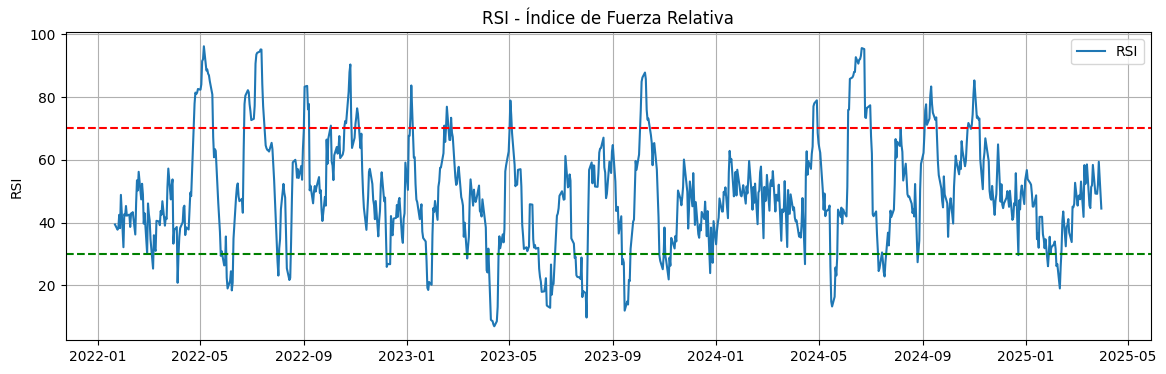

In [7]:
# Función RSI
def calcular_RSI(data, window=14):
    delta = data.diff()
    ganancia = delta.clip(lower=0)
    perdida = -1 * delta.clip(upper=0)
    avg_gain = ganancia.rolling(window=window).mean()
    avg_loss = perdida.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calcular y graficar RSI
df['RSI'] = calcular_RSI(df['Close'])

plt.figure(figsize=(14,4))
plt.plot(df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI - Índice de Fuerza Relativa')
plt.ylabel('RSI')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
import numpy as np

In [9]:
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
df['target'] = df['Close'].shift(-1)
for i in range(1, 6):
    df[f'lag_{i}'] = df['Close'].shift(i)

# Instead of dropping all rows with NaNs, fill them with the previous valid value:
df_model = df[['Close', 'SMA_30', 'EMA_30', 'RSI', 'log_ret', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'target']].fillna(method='ffill')

df_model.head()



<ipython-input-9-b2a240bb4e3a>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model = df[['Close', 'SMA_30', 'EMA_30', 'RSI', 'log_ret', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'target']].fillna(method='ffill')


Price,Close,SMA_30,EMA_30,RSI,log_ret,lag_1,lag_2,lag_3,lag_4,lag_5,target
Ticker,USDCOP=X,,,,,,,,,,
Date,,,,,,,,,,,
2022-01-03,4063.580078,NaN,4063.580078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4063.080078
2022-01-04,4063.080078,NaN,4063.547820,NaN,-0.000123,4063.580078,NaN,NaN,NaN,NaN,4078.550049
2022-01-05,4078.550049,NaN,4064.515706,NaN,0.003800,4063.080078,4063.580078,NaN,NaN,NaN,4026.919922
2022-01-06,4026.919922,NaN,4062.090171,NaN,-0.012740,4078.550049,4063.080078,4063.580078,NaN,NaN,4030.919922
2022-01-07,4030.919922,NaN,4060.079188,NaN,0.000993,4026.919922,4078.550049,4063.080078,4063.580078,NaN,3970.704834


In [10]:
from sklearn.model_selection import train_test_split

# Features y Target
X = df_model.drop('target', axis=1)
y = df_model['target']

# División 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


<ipython-input-10-c16ddb62ced7>:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_model.drop('target', axis=1)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Crear modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 44.03
MAE: 34.07


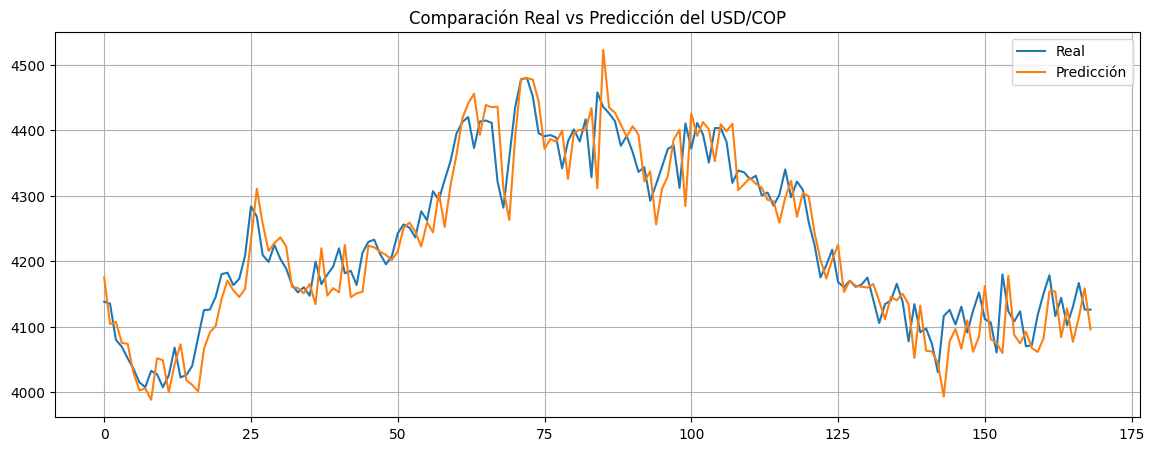

In [12]:
plt.figure(figsize=(14,5))
plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Predicción')
plt.title("Comparación Real vs Predicción del USD/COP")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
X = df_model.drop('target', axis=1)
y = df_model['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fill NaN values in X_train and X_test again
# Applying fillna after the split ensures that any NaNs introduced in X_test by lag features are filled as well.
# Using both 'ffill' and 'bfill' to ensure all NaNs are filled.
X_train = X_train.fillna(method='ffill').fillna(method='bfill')
X_test = X_test.fillna(method='ffill').fillna(method='bfill')

# Entrenamiento del modelo
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
# Asegúrate de que no queden NaN
if X_train.isnull().values.any() or X_test.isnull().values.any():
    print("Cuidado: aún hay valores NaN en los datos.")
else:
    print("✔️ No hay valores NaN. Todo listo para entrenar.")

✔️ No hay valores NaN. Todo listo para entrenar.


<ipython-input-13-6777ca7ff258>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_model.drop('target', axis=1)
<ipython-input-13-6777ca7ff258>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_train.fillna(method='ffill').fillna(method='bfill')
<ipython-input-13-6777ca7ff258>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method='ffill').fillna(method='bfill')


# **Evaluación del Modelo**

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Cálculo de métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📈 MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"📈 RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"📈 MAE (Error Absoluto Medio): {mae:.4f}")
print(f"📈 R² (Coeficiente de Determinación): {r2:.4f}")


📈 MSE (Error Cuadrático Medio): 1294.8203
📈 RMSE (Raíz del Error Cuadrático Medio): 35.9836
📈 MAE (Error Absoluto Medio): 28.5016
📈 R² (Coeficiente de Determinación): 0.9154


MSE y RMSE → Son relativamente bajos dependiendo del rango de valores de Close. Un RMSE de ~36 indica que en promedio tu modelo se equivoca por ±36 unidades de moneda (COP).

MAE → El error absoluto medio (28.5) es bastante aceptable para un primer modelo simple.

R² = 0.9154 → ¡Muy bueno! 🔥
Significa que el 91.5% de la variabilidad de los precios futuros está siendo explicada por tu modelo.